## 【ポアソン分布】野菜の収穫量

野菜の収穫量のデータをポアソン分布へあてはめてみる。

In [1]:
import pymc as pm
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['font.size'] = 12

## Load & Check Data

In [3]:
data = pd.read_csv('data.csv')

In [5]:
data.head(3)

,yield,group
0,7,0
1,13,0
2,13,0


In [6]:
x = data.query('group == 0')['yield'].values

print(x)

[ 7 13 13 11  5  6  8 11 10 11 11 11 11 14  8 15 10  9 13 12  8 15  7 11
  5 11 15 10 13  9  8 12 13  6  8  5 13  8  5 10 18  9  7 12 11  5  9 10
 13 13]


In [7]:
x.shape

(50,)

In [8]:
np.mean(x)

10.16

In [9]:
np.var(x)

9.1744

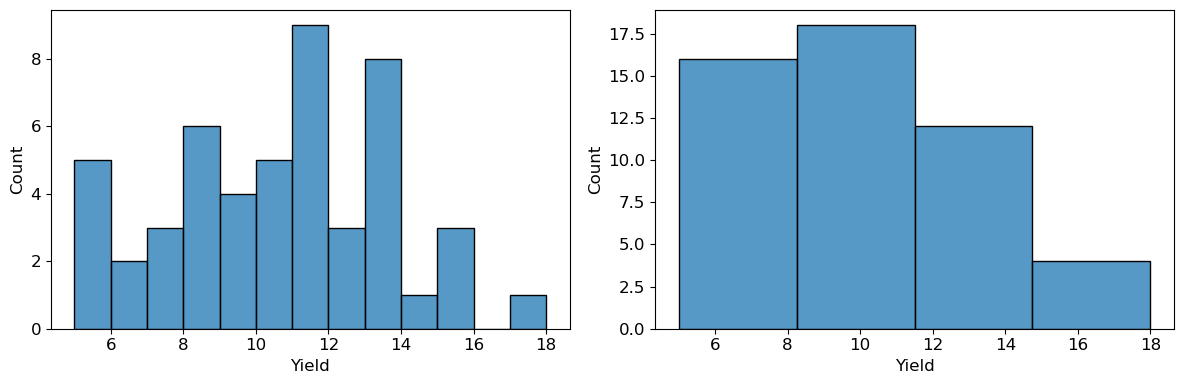

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(x, binwidth=1, ax=axes[0])
axes[0].set_xlabel('Yield')

sns.histplot(x, binwidth=3, ax=axes[1])
axes[1].set_xlabel('Yield')

plt.tight_layout()

## Define Model & Inference

In [12]:
with pm.Model() as model:

    mu = pm.HalfNormal('mu', sigma=10)

    obs = pm.Poisson('obs', mu=mu, observed=x)

model

 mu ~ HalfNormal(0, 10)
obs ~ Poisson(mu)

In [13]:
with model:
    trace = pm.sample(3000, return_inferencedata=False)
    idata = pm.to_inference_data(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


pm.sample 関数は、return_inferencedata を False に指定しないと、戻り値が InferenceData Object になります。

**pm.sample 関数**：
https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html

## Check MultiTrace Object & InferenceData Object

In [14]:
trace

<MultiTrace: 4 chains, 3000 iterations, 2 variables>

In [15]:
trace['mu']

array([ 9.94960414,  9.84885194,  9.66702849, ..., 10.3594263 ,
       10.23180839, 10.24098136])

In [16]:
trace['mu'].shape

(12000,)

In [17]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [18]:
idata.posterior['mu']

<xarray.DataArray 'mu' (chain: 4, draw: 3000)> Size: 96kB
array([[ 9.94960414,  9.84885194,  9.66702849, ..., 10.46712751,
        10.46712751, 10.52443592],
       [ 9.87004204,  9.30347303,  9.35153193, ...,  9.78943714,
        10.80693944, 10.3709304 ],
       [10.27474209, 10.95921449, 10.25598684, ..., 10.30165457,
        10.42388069, 10.42388069],
       [10.65562799,  9.69570687, 10.75641929, ..., 10.3594263 ,
        10.23180839, 10.24098136]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 24kB 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999

In [19]:
idata.posterior['mu'].shape

(4, 3000)

## Check MCMC-samples

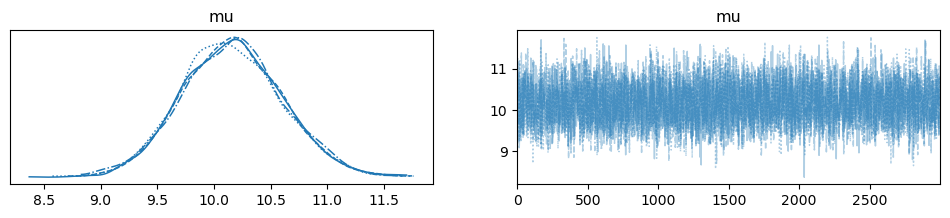

In [20]:
az.plot_trace(idata);

In [21]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,10.158,0.446,9.3,10.984,0.006,0.004,5171.0,7797.0,1.0


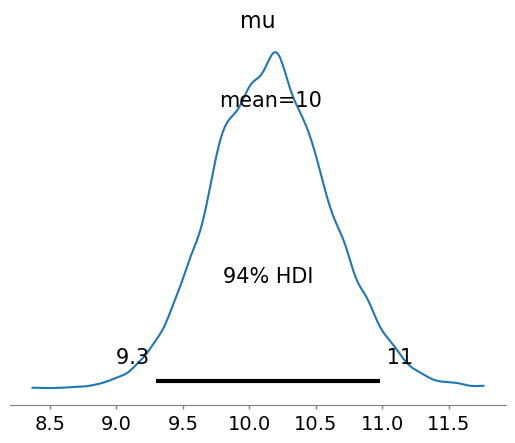

In [22]:
az.plot_posterior(idata);
#az.plot_posterior(idata, hdi_prob=0.95);

## Posterior Predictive Check

In [23]:
with model:
    ppc = pm.sample_posterior_predictive(idata, return_inferencedata=False)
    idata_ppc = pm.to_inference_data(posterior_predictive=ppc)

Sampling: [obs]


Output()

pm.sample_posterior_predictive 関数には、InfereceData Object である idata を渡しても、 MultiTrace Object である trace を渡しても、同じように動きます。

pm.sample_posterior_predictive 関数：
https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample_posterior_predictive.html

In [24]:
ppc_samples = ppc['obs']
ppc_samples.shape

(4, 3000, 50)

In [25]:
ppc_samples = ppc_samples.reshape(-1, 50)
ppc_samples.shape

(12000, 50)

In [26]:
# 記述統計量（平均・分散）によるチェック

ppc_mean = ppc_samples.mean(axis=1)
ppc_var = ppc_samples.var(axis=1)

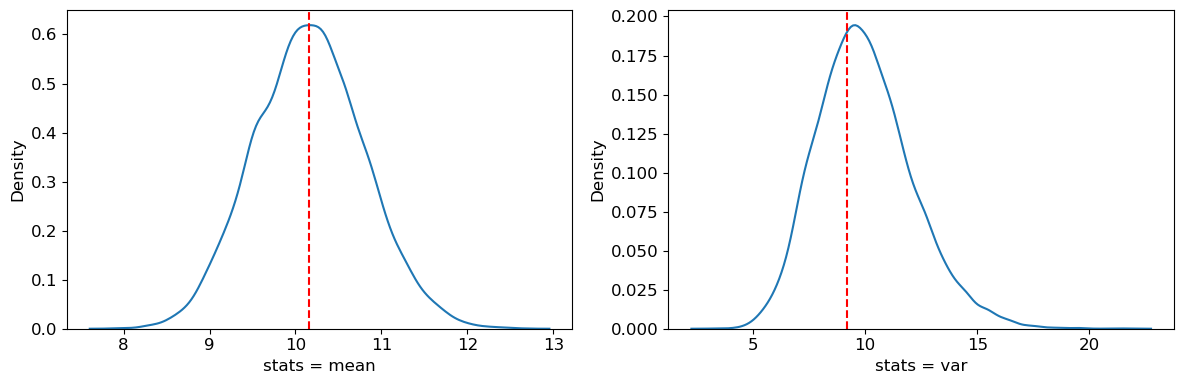

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.kdeplot(ppc_mean, ax=axes[0])
axes[0].axvline(x.mean(), color='r', linestyle='dashed')
axes[0].set_xlabel('stats = mean')

sns.kdeplot(ppc_var, ax=axes[1])
axes[1].axvline(x.var(), color='r', linestyle='dashed')
axes[1].set_xlabel('stats = var')

plt.tight_layout()

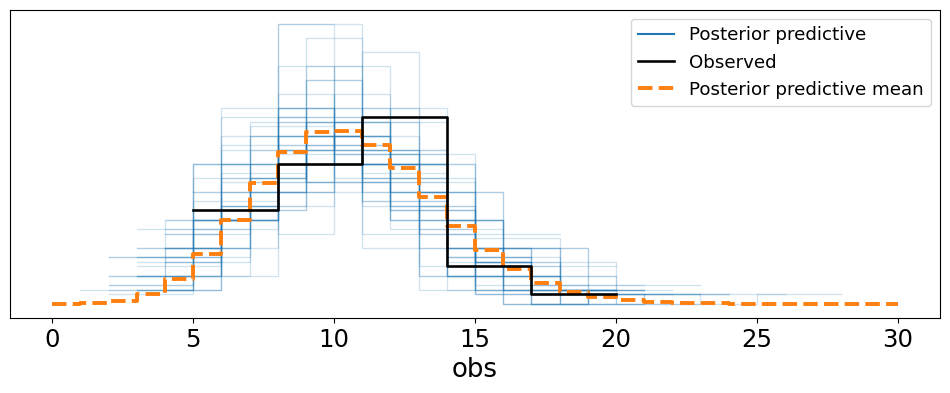

In [28]:
# 分布によるチェック

az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=50, figsize=(12, 4));

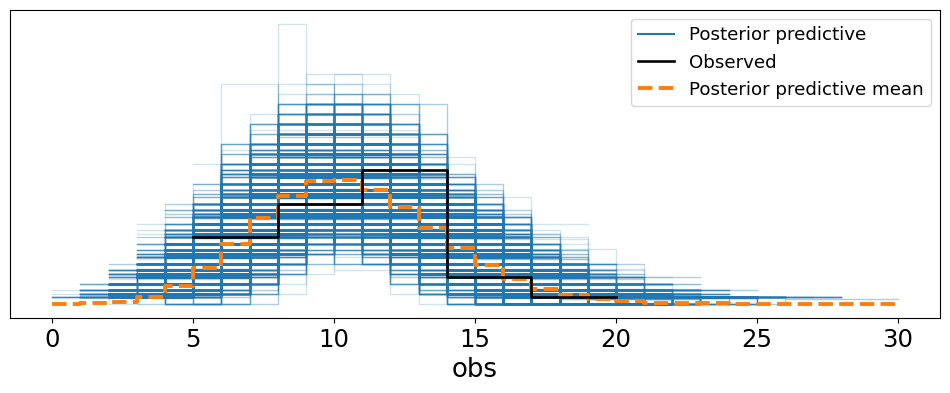

In [29]:
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=3000, figsize=(12, 4));